In [1]:
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
import torch
from torchvision.transforms import transforms
import torchvision
import pandas as pd
class DonedealImageDataset(Dataset):
    def __init__(self, root_dir, \
        transform=transforms.Compose([transforms.ToTensor()]), label_mapping={}):
        self.transform = transform
        self.label_mapping = label_mapping
        self.root_dir = root_dir
        self.filenames = os.listdir(root_dir)
    
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        imageHq = cv2.imread(self.root_dir+self.filenames[idx])/255.0

        image = cv2.resize(imageHq, (int(imageHq.shape[0] / 3), \
            int(imageHq.shape[1] / 3)), \
                interpolation = cv2.INTER_AREA)

        image = self.transform(image).float()
        # get label
        if "Kia" in self.filenames[idx]:
            label = 0
        if "Skoda" in self.filenames[idx]:
            label = 1
        if "Toyota" in self.filenames[idx]:
            label = 2
        if "Volkswagen" in self.filenames[idx]:
            label = 3
        label = torch.tensor(label)
        return image, label

batch_size = 32
classes = ('Kia', 'Skoda', 'Toyota', 'Volkswagen')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     
trainset = DonedealImageDataset(root_dir='./traindata/', transform=transform)
testset = DonedealImageDataset(root_dir='./testdata/', transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

/home/admyyh/kaggle/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


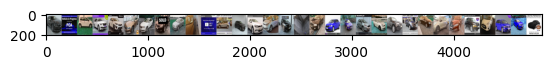

Volkswagen Toyota Volkswagen Skoda Kia   Volkswagen Skoda Volkswagen Toyota Skoda Skoda Kia   Kia   Volkswagen Volkswagen Toyota Skoda Skoda Skoda Kia   Kia   Volkswagen Skoda Kia   Volkswagen Toyota Volkswagen Skoda Toyota Volkswagen Volkswagen Volkswagen


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images, nrow=32))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [23]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.LazyLinear(84),
            nn.LazyLinear(4),
        )

    def forward(self, x):
        return self.block(x)

net = Net().to("cuda")

/home/admyyh/kaggle/venv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [21]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to("cuda"), data[1].to("cuda")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}] loss: {running_loss / 2000:.3f}')
    running_loss = 0.0

print('Finished Training')

Finished Training


In [24]:
PATH = './donedeal_brand_classification.pth'
torch.save(net.state_dict(), PATH)

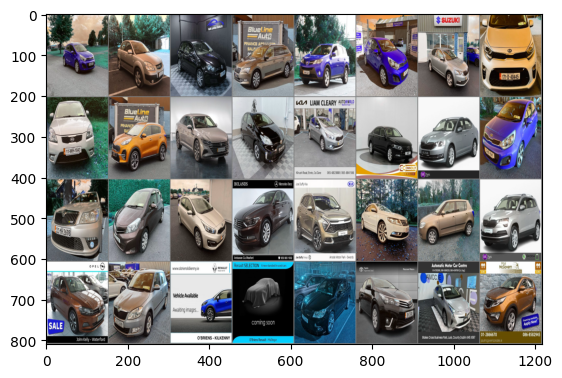

GroundTruth:  Kia   Kia   Volkswagen Skoda Toyota Kia   Skoda Kia   Kia   Kia   Volkswagen Toyota Kia   Volkswagen Skoda Kia   Skoda Toyota Kia   Volkswagen Kia   Volkswagen Skoda Skoda Volkswagen Skoda Kia   Kia   Skoda Toyota Toyota Kia  


In [25]:
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
images = images.to("cuda")
labels = labels.to("cuda")
# print images


In [13]:
net = Net()
net.load_state_dict(torch.load(PATH))
net = net.to("cuda")

/home/admyyh/kaggle/venv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [26]:
outputs = net(images)

In [27]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  Toyota Skoda Skoda Skoda Skoda Skoda Toyota Toyota Toyota Toyota Skoda Skoda Toyota Toyota Skoda Toyota Toyota Toyota Skoda Toyota Skoda Toyota Skoda Skoda Toyota Skoda Skoda Skoda Skoda Toyota Toyota Toyota


In [28]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to("cuda")
        labels = labels.to("cuda")
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 23 %


In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Kia   is 55.5 %
Accuracy for class: Skoda is 7.1 %
Accuracy for class: Toyota is 59.9 %
Accuracy for class: Volkswagen is 7.9 %
